# 📙 Libraries

In [2]:
#@title  📙 Packages to install
#!pip install -q dimod
#!pip install -q pyqubo
#!pip install -q dwave.system

In [1]:
#@title 📙 Packages to import

import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
from scipy.optimize import nnls

import cvxpy as cp

from decimal import getcontext, Decimal, setcontext
#getcontext().prec = 50  # Define a precisão para 50 dígitos


from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client
from dwave.embedding.chain_strength import uniform_torque_compensation

import dimod
import neal

from pyqubo import Array #Python library that allows you to create QUBO or Ising models from flexible mathematical expressions

from pprint import *

# ⏯ QUBO least square for $h \in \{0,1\}^{\ell \times 1}$

The objective is creating an algorithm to solve Minimum Least Square problem
$$\begin{array}{l}
\min\limits_{h \in \{0,1\}^{\ell \times 1}} \|Wh-v\|_F^2,
\end{array}$$
where $W \in \mathbb{R}^{m \times \ell}$ and $v \in \mathbb{R}^{m \times 1}$, to find $h \in \{0,1\}^{\ell \times 1}$ using classical and D-Wave Quantum Computer.

In [2]:
#@title ⏯ `random_positive_matrix` definition

def random_positive_matrix(m,n,delta=1):
    M = np.random.randn(m, n)
    matrix = delta*M/np.amax(M) # np.amax retorna o maior elemento de uma matriz
    return np.round(abs(matrix),5)

random_positive_matrix(m=5,n=4,delta=1)

array([[0.21841, 0.29989, 0.24905, 0.79446],
       [0.38175, 0.11114, 0.33629, 1.     ],
       [0.23938, 0.44385, 0.01369, 0.58783],
       [0.4242 , 0.22467, 0.63276, 0.21905],
       [0.56861, 0.39187, 0.14827, 0.78909]])

In [3]:
#@title ⏯ Generating data

m = 5 # número de linhas de V
n = 4 # número de colunas de V
l = 2 # n_factors
k = 8 # n_qubits
p = 0.5 # probabilidade de sucesso na distribuição binomial
z = -1 # n_int_power (número de potências inteiras no vetor de precisão)
n_iter = 10
n_read = 20

np.random.seed(1)

delta = 1
W_original = random_positive_matrix(m,l,delta)
W_inicial = random_positive_matrix(m,l,delta)

#H_original = random_positive_matrix(l,n,delta) #np.random.randn(l,n)
#H_inicial = random_positive_matrix(l,n,delta)
H_original = np.array([np.random.binomial(1, p, n) for _ in range(l)])
H_inicial = np.array([np.random.binomial(1, p, n) for _ in range(l)])

V_original = W_original@H_original # Linear mixing model
V = V_original
H_inicial
print(f'\n\n WH = V:\n {V_original} \n\n W:\n {W_original} \n\n H:\n {H_original} \n\n W_inicial:\n {W_inicial}')
#print(f'V:\n {W_original}')



 WH = V:
 [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 W:
 [[0.93096 0.35061]
 [0.30271 0.61495]
 [0.49599 1.31908]
 [1.      0.43627]
 [0.18285 0.14292]] 

 H:
 [[1 0 1 1]
 [0 1 1 1]] 

 W_inicial:
 [[1.      1.40902]
 [0.22052 0.26267]
 [0.77543 0.75226]
 [0.11793 0.60041]
 [0.02887 0.39861]]


## ⏯ Step by step `qubo_ls`

In [11]:
n_factors = l
n_qubits = k

y = Array.create('y', shape=(n_factors,1), vartype='BINARY')[:,0]

y

vector = V[:,0]
W = W_inicial

linear = -2*vector.T@W
pprint(np.diag(linear))
pprint(np.diag(linear).shape)

quadratic = W.T@W

quadratic

Q = quadratic + np.diag(linear) #+ 0.001 * np.eye(n_factors*n_qubits)

print(Q)

G = 0*y[0]
for i in range(0, n_factors):
    for j in range(0, n_factors):
        G += Q[i,j]*y[i]*y[j]

G

model = G.compile() # preparando o problema para ser resolvido em um computador quantico
bqm = model.to_bqm() # Creating BQM model

array([[-9.95817875,  0.        ],
       [ 0.        , -9.98302004]])
(2, 2)
[[-2.91261266  4.54619864]
 [ 4.54619864 -3.07519823]]


In [9]:
sampler_SA = neal.SimulatedAnnealingSampler() # Using Simulated Annealing as Sampler
sampleset_SA = sampler_SA.sample(bqm, num_reads=n_read) # Sampling the bqm model
sampleset_data = sampleset_SA.record.sample
sampleset_energy = sampleset_SA.record.energy

index_t = np.argsort(sampleset_energy)
best_sample = sampleset_data[index_t[0],:]

y_sol = best_sample.reshape(1,n_factors)
y_sol

array([[0, 1]], dtype=int8)

In [10]:
sampler = DWaveSampler(solver=dict(topology__type="pegasus"),token='DEV-c0e1f27ddffec3f557c2fb2537dfd76ce825380d')
print(f"Selected {sampler.solver.name} with {len(sampler.nodelist)} qubits.")

# Calcula o chain strength
embedding_sampler = EmbeddingComposite(sampler)
chain_strength = uniform_torque_compensation(bqm)
print(chain_strength)
response = embedding_sampler.sample_qubo(Q, chain_strength=chain_strength, num_reads=100)
print(response)

Selected Advantage_system6.4 with 5612 qubits.
6.030945239261599
   0  1    energy num_oc. chain_.
0  0  1 -1.735717      77     0.0
1  1  0 -1.346394      22     0.0
2  0  0       0.0       1     0.0
['BINARY', 3 rows, 100 samples, 2 variables]


In [11]:
sampler_quantum = EmbeddingComposite(DWaveSampler(solver={'qpu': True, 'topology__type': 'pegasus'},chain_strength=chain_strength,token='DEV-c0e1f27ddffec3f557c2fb2537dfd76ce825380d')) # 'pegasus, 'zephyr' (não disponivel comercialmente)
sampleset_quantum = sampler_quantum.sample(bqm, num_reads=n_read) # Sampling the bqm model
sampleset_data = sampleset_quantum.record.sample
sampleset_energy = sampleset_quantum.record.energy

# ⏯ `qubo_binls`

In [4]:
def qubo_binls(vector, W, n_factors=l, sampler='SA', n_reads=n_read):
    key1 = 'DEV-c0e1f27ddffec3f557c2fb2537dfd76ce825380d' #nascimento.p
    key2 = 'DEV-50876c318b794d762ddea8ba6ce811fc29fe0ebe' #e-neper

    y = Array.create('y', shape=(n_factors,1), vartype='BINARY')[:,0] # vetor de variáveis binárias simbólicas da matriz misturada
    lambda_value = 1e-4

    linear = -2*vector.T@W # matriz dos coeficientes dos termos lineares
    quadratic = W.T@W # matriz dos termos quadráticos (including squared terms)
    Q = quadratic + np.diag(linear) + lambda_value * np.eye(n_factors) # matriz que reune os termos lineares e quadraticos

    G = 0*y[0]
    for i in range(0, n_factors):
        for j in range(0, n_factors):
            G += Q[i,j]*y[i]*y[j]

    model = G.compile() # preparando o problema para ser resolvido em um computador quantico
    bqm = model.to_bqm() # Creating BQM model

    ## Performing sampling of QUBO model
    if sampler=='EXACT':
        sampler_exact = dimod.ExactSolver() # Defining an exact sampler
        sampleset_exact = sampler_exact.sample_qubo(Q)#, num_reads=n_reads)
        sampleset_data = sampleset_exact.record.sample
        sampleset_energy = sampleset_exact.record.energy

    if sampler=='SA':
        sampler_SA = neal.SimulatedAnnealingSampler() # Using Simulated Annealing as Sampler
        sampleset_SA = sampler_SA.sample(bqm, num_reads=n_reads) # Sampling the bqm model
        sampleset_data = sampleset_SA.record.sample
        sampleset_energy = sampleset_SA.record.energy

    if sampler=='QUANTUM':
        chain_strength = uniform_torque_compensation(bqm)
        sampler_quantum = EmbeddingComposite(DWaveSampler(solver={'qpu': True, 'topology__type': 'pegasus'},chain_strength=chain_strength,token=key2)) # 'pegasus, 'zephyr' (não disponivel comercialmente)
        sampleset_quantum = sampler_quantum.sample(bqm, num_reads=n_reads) # Sampling the bqm model
        sampleset_data = sampleset_quantum.record.sample
        sampleset_energy = sampleset_quantum.record.energy

    index_t = np.argsort(sampleset_energy)
    best_sample = sampleset_data[index_t[0],:]

    #DF_samples = sampleset_exact.to_pandas_dataframe() # Extracting samples as a pandas dataframe
    #temp = DF_samples.to_numpy()
    #ahat_temp = temp[0,0:N].T # Extracting mixing coefficients
    y_sol = best_sample.reshape(1,n_factors)
    return y_sol

In [19]:
qubo_binls(vector=V[:,0], W=W_inicial,sampler='EXACT')

array([[0, 1]], dtype=int8)

In [20]:
qubo_binls(vector=V[:,0], W=W_inicial,sampler='SA')

array([[0, 1]], dtype=int8)

In [12]:
qubo_binls(vector=V[:,0], W=W_inicial,sampler='QUANTUM')

array([[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]],
      dtype=int8)

# ⏯ Definition of the function that uses ALS in the quantum computer

The objective is creatting an algorithm to solve NMF problem $V \approx WH$ with ALS using D-Wave Quantum Computer.

In [5]:
def quantum_binals(matrix, W = W_inicial, n_factors=l, sampler='SA', n_reads=n_read, n_iters=n_iter):
    m, n = matrix.shape
    residuals = np.zeros(n_iters)
    iter_list = np.linspace(1,n_iters,n_iters)
    H = np.zeros((n_factors,n))

    for iter_num in range(1,2*n_iters+1):
        if iter_num % 2 == 1:
            for j in range(n):
                H[:,j] = qubo_binls(matrix[:,j], W, n_factors, sampler, n_reads)#, n_factors, sampler, n_reads, api_key=token)
        else:
            for i in range(m):
                #W[i] = qubo_ls(matrix[i], H, n_factors, n_qubits, n_int_power, sampler, n_reads)#vector, X
                W[i] = np.linalg.lstsq(H.T, matrix[i,:], rcond=None)[0].T#vector, X
        if iter_num % 2 ==0:
            residuals[int(iter_num/2-1)] = np.linalg.norm(matrix-W@H,'fro')
            #print('Iteration {}, residual norm {}'.format(int(iter_num/2), residuals[int(iter_num/2-1)]))
    rmse = np.sqrt(np.mean(np.square(residuals)))
    return W, H, residuals, rmse, iter_list

# ⏯ Definition of the function solve_nnls e anls

In [23]:
def solve_nnls(A, B):
    X = np.zeros((A.shape[1], B.shape[1]))
    for i in range(B.shape[1]):
        X[:, i], _ = nnls(A, B[:, i], maxiter=10000)
    return X

# ANLS (Alternating Nonnegative Least Squares)
def anls(matrix, W = W_inicial, n_factors=l, n_iters=n_iter):
    m, n = matrix.shape
    np.random.seed(0)
    residuals = np.zeros(n_iters)
    iter_list = np.linspace(1,n_iters,n_iters)

    for iter_num in range(1,2*n_iters+1):
        if iter_num % 2 == 1:
            H = solve_nnls(W.T@W, W.T@matrix)
        else:
            W = solve_nnls(H@H.T, H@matrix.T).T
        if iter_num % 2 ==0:
            residuals[int(iter_num/2-1)] = np.linalg.norm(matrix-W@H,'fro')
            #print('Iteration {}, residual norm {}'.format(int(iter_num/2), residuals[int(iter_num/2-1)]))
    rmse = np.sqrt(np.mean(np.square(residuals)))
    return W, H, residuals, rmse, iter_list

## ⏯ Comparison between exact and simulated annealing NMF ALS methods

In [33]:
#k = 6
#n_read = 20
#n_iter = 25

W_ex, H_ex, residuals_ex, rmse_ex, iter_list_ex = quantum_binals(V_original, W_inicial, n_factors=l, sampler='EXACT', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_ex,'\n\n','H=',H_ex,'\n\n','WH=',W_ex@H_ex,'\n\n','RMSE=',rmse_ex)

V= [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 W= [[0.35061 0.93096]
 [0.61495 0.30271]
 [1.31908 0.49599]
 [0.43627 1.     ]
 [0.14292 0.18285]] 

 H= [[0. 1. 1. 1.]
 [1. 0. 1. 1.]] 

 WH= [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 RMSE= 1.5862013993650003e-15


In [34]:
W_sa, H_sa, residuals_sa, rmse_sa, iter_list_sa = quantum_binals(V_original, W_inicial, n_factors=l, sampler='SA', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_sa,'\n\n','H=',H_sa,'\n\n','WH=',W_sa@H_sa,'\n\n','RMSE=',rmse_sa)

V= [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 W= [[0.35061 0.93096]
 [0.61495 0.30271]
 [1.31908 0.49599]
 [0.43627 1.     ]
 [0.14292 0.18285]] 

 H= [[0. 1. 1. 1.]
 [1. 0. 1. 1.]] 

 WH= [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 RMSE= 1.5862013993650003e-15


In [35]:
W_qu, H_qu, residuals_qu, rmse_qu, iter_list_qu = quantum_binals(V_original, W_inicial, n_factors=l, sampler='QUANTUM', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_qu,'\n\n','H=',H_qu,'\n\n','WH=',W_qu@H_qu,'\n\n','RMSE=',rmse_qu)

V= [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 W= [[0.35061 0.93096]
 [0.61495 0.30271]
 [1.31908 0.49599]
 [0.43627 1.     ]
 [0.14292 0.18285]] 

 H= [[0. 1. 1. 1.]
 [1. 0. 1. 1.]] 

 WH= [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 RMSE= 1.5862013993650003e-15


## ⏯ Graph: Residuals

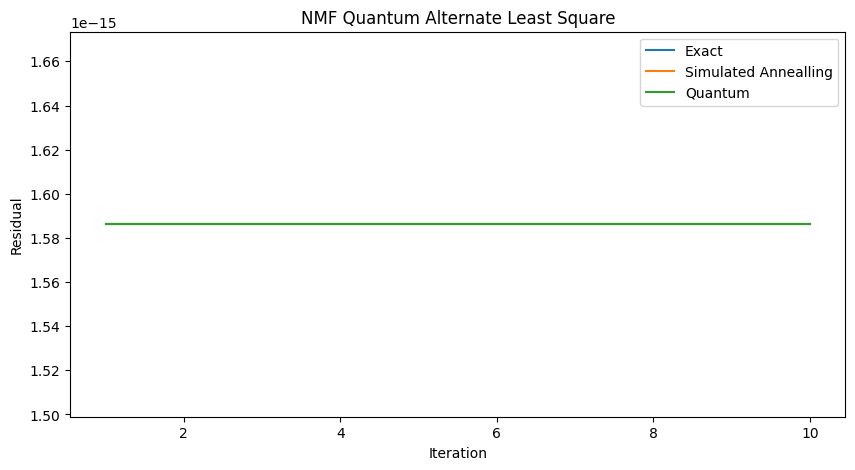

In [36]:
plt.figure(figsize=(10,5))

plt.title('NMF Quantum Alternate Least Square')
plt.plot(iter_list_ex, residuals_ex,'-',ms=2, label='Exact')#,label='residuals '+str(i+1))
plt.plot(iter_list_sa, residuals_sa,'-',ms=2,label='Simulated Annealling')#,label='residuals '+str(i+1))
plt.plot(iter_list_qu, residuals_qu,'-',ms=2,label='Quantum')#,label='residuals '+str(i+1))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residual')
#plt.xticks(np.arange(min(iter_list_exact)-1, max(iter_list_exact)+2, 2.0)) # para mostrar as iterações com espaçamento unitário
#plt.yticks(np.arange(min(np.round(residuals_exact,0))-1, max(np.round(residuals_exact,2))+1, 1.0)) # para mostrar as iterações com espaçamento unitário
plt.savefig('bin01.png', format='png')
plt.show()

## ⏯ Graph: Execution's Number x Residuals

In [57]:
#@title Graphical visualization appling quantum_als with exact sampler
eixo_x = []
eixo_y1 = []
eixo_y2 = []
n_executions = 10
for i in range(n_executions):
    W, H, residuals, rmse, iter_list = quantum_binals(V_original, W_inicial, sampler='SA')
    eixo_x.append(iter_list)
    eixo_y1.append(residuals)
    eixo_y2.append(rmse)

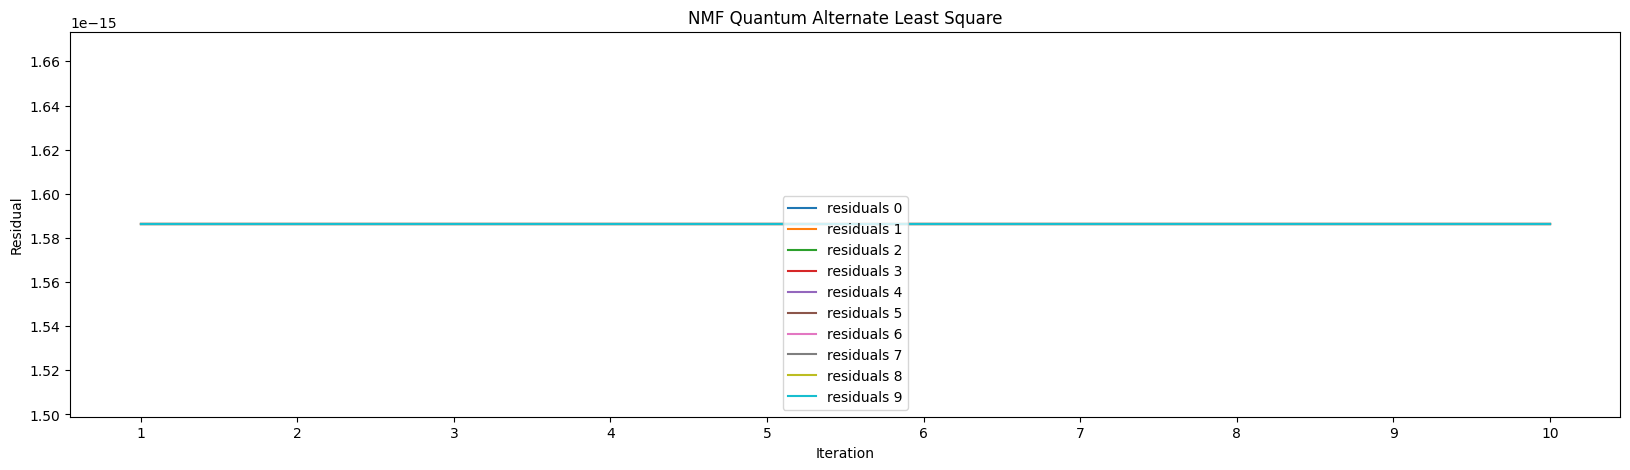

In [58]:
plt.figure(figsize=(20,5))
for i in range(n_executions):
    plt.plot(eixo_x[i], eixo_y1[i],'-',ms=2,label='residuals '+str(i+0))

plt.title('NMF Quantum Alternate Least Square')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.xticks(np.arange(min(iter_list), max(iter_list)+1, 1.0)) # para mostrar as iterações com espaçamento unitário
#plt.yticks(np.arange(min(residuals), max(residuals), 0.0001)) # para mostrar as iterações com espaçamento unitário
plt.show()

## ⏯ Comparison with classical computing solution

In [62]:
W_class, H_class, residuals_class, rmse_class, iter_list_class = anls(V, W_inicial)
print(V,'\n\n', W@H,'\n\n',W_class@H_class,'\n\n',W_class@H_class)

[[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]] 

 [[0.93096 0.35061 1.28157 1.28157]
 [0.30271 0.61495 0.91766 0.91766]
 [0.49599 1.31908 1.81507 1.81507]
 [1.      0.43627 1.43627 1.43627]
 [0.18285 0.14292 0.32577 0.32577]]


# Caso 2

In [11]:
#@title ⏯ Generating data

m = 50 # número de linhas de V
n = 40 # número de colunas de V
l = 2 # n_factors
k = 8 # n_qubits
p = 0.5 # probabilidade de sucesso na distribuição binomial
z = -1 # n_int_power (número de potências inteiras no vetor de precisão)
n_iter = 10
n_read = 20

np.random.seed(1)

delta = 1
W_original = random_positive_matrix(m,l,delta)
W_inicial = random_positive_matrix(m,l,delta)

#H_original = random_positive_matrix(l,n,delta) #np.random.randn(l,n)
#H_inicial = random_positive_matrix(l,n,delta)
H_original = np.array([np.random.binomial(1, p, n) for _ in range(l)])
H_inicial = np.array([np.random.binomial(1, p, n) for _ in range(l)])

V_original = W_original@H_original # Linear mixing model
V = V_original
#H_inicial
#print(f'\n\n WH = V:\n {V_original} \n\n W:\n {W_original} \n\n H:\n {H_original} \n\n W_inicial:\n {W_inicial}')
#print(f'V:\n {W_original}')

In [12]:
W_ex, H_ex, residuals_ex, rmse_ex, iter_list_ex = quantum_binals(V_original, W_inicial, n_factors=l, sampler='EXACT', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_ex,'\n\n','H=',H_ex,'\n\n','WH=',W_ex@H_ex,'\n\n','RMSE=',rmse_ex)

V= [[0.74321 0.      0.74321 ... 1.02312 1.02312 1.02312]
 [0.24166 0.      0.24166 ... 0.73259 0.73259 0.73259]
 [0.39596 0.      0.39596 ... 1.44902 1.44902 1.44902]
 ...
 [0.19377 0.      0.19377 ... 0.22916 0.22916 0.22916]
 [0.15733 0.      0.15733 ... 0.17728 0.17728 0.17728]
 [0.28368 0.      0.28368 ... 0.60306 0.60306 0.60306]] 

 W= [[0.27991 0.74321]
 [0.49093 0.24166]
 [1.05306 0.39596]
 [0.34829 0.79833]
 [0.1141  0.14597]
 [0.94261 0.66898]
 [0.17572 0.14752]
 [0.50325 0.51875]
 [0.40166 0.07889]
 [0.26666 0.01931]
 [0.52376 0.50358]
 [0.22991 0.41252]
 [0.31284 0.41218]
 [0.42816 0.05623]
 [0.24266 0.12257]
 [0.18153 0.31647]
 [0.38672 0.31441]
 [0.00579 0.30713]
 [0.10726 0.51122]
 [0.33952 0.75943]
 [0.40613 0.08777]
 [0.77437 0.34186]
 [0.29145 0.02325]
 [0.96096 0.08735]
 [0.2824  0.05498]
 [0.16117 0.13734]
 [0.15984 0.52275]
 [0.26841 0.09558]
 [0.42602 0.38387]
 [0.40499 0.13067]
 [0.57324 0.34517]
 [0.13639 0.23469]
 [0.03458 0.22352]
 [0.69539 0.51777]
 [0.63896

In [13]:
W_sa, H_sa, residuals_sa, rmse_sa, iter_list_sa = quantum_binals(V_original, W_inicial, n_factors=l, sampler='SA', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_sa,'\n\n','H=',H_sa,'\n\n','WH=',W_sa@H_sa,'\n\n','RMSE=',rmse_sa)

V= [[0.74321 0.      0.74321 ... 1.02312 1.02312 1.02312]
 [0.24166 0.      0.24166 ... 0.73259 0.73259 0.73259]
 [0.39596 0.      0.39596 ... 1.44902 1.44902 1.44902]
 ...
 [0.19377 0.      0.19377 ... 0.22916 0.22916 0.22916]
 [0.15733 0.      0.15733 ... 0.17728 0.17728 0.17728]
 [0.28368 0.      0.28368 ... 0.60306 0.60306 0.60306]] 

 W= [[0.27991 0.74321]
 [0.49093 0.24166]
 [1.05306 0.39596]
 [0.34829 0.79833]
 [0.1141  0.14597]
 [0.94261 0.66898]
 [0.17572 0.14752]
 [0.50325 0.51875]
 [0.40166 0.07889]
 [0.26666 0.01931]
 [0.52376 0.50358]
 [0.22991 0.41252]
 [0.31284 0.41218]
 [0.42816 0.05623]
 [0.24266 0.12257]
 [0.18153 0.31647]
 [0.38672 0.31441]
 [0.00579 0.30713]
 [0.10726 0.51122]
 [0.33952 0.75943]
 [0.40613 0.08777]
 [0.77437 0.34186]
 [0.29145 0.02325]
 [0.96096 0.08735]
 [0.2824  0.05498]
 [0.16117 0.13734]
 [0.15984 0.52275]
 [0.26841 0.09558]
 [0.42602 0.38387]
 [0.40499 0.13067]
 [0.57324 0.34517]
 [0.13639 0.23469]
 [0.03458 0.22352]
 [0.69539 0.51777]
 [0.63896

In [42]:
W_qu, H_qu, residuals_qu, rmse_qu, iter_list_qu = quantum_binals(V_original, W_inicial, n_factors=l, sampler='QUANTUM', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_qu,'\n\n','H=',H_qu,'\n\n','WH=',W_qu@H_qu,'\n\n','RMSE=',rmse_qu)

V= [[0.74321 0.      0.74321 ... 1.02312 1.02312 1.02312]
 [0.24166 0.      0.24166 ... 0.73259 0.73259 0.73259]
 [0.39596 0.      0.39596 ... 1.44902 1.44902 1.44902]
 ...
 [0.19377 0.      0.19377 ... 0.22916 0.22916 0.22916]
 [0.15733 0.      0.15733 ... 0.17728 0.17728 0.17728]
 [0.28368 0.      0.28368 ... 0.60306 0.60306 0.60306]] 

 W= [[0.27991 0.74321]
 [0.49093 0.24166]
 [1.05306 0.39596]
 [0.34829 0.79833]
 [0.1141  0.14597]
 [0.94261 0.66898]
 [0.17572 0.14752]
 [0.50325 0.51875]
 [0.40166 0.07889]
 [0.26666 0.01931]
 [0.52376 0.50358]
 [0.22991 0.41252]
 [0.31284 0.41218]
 [0.42816 0.05623]
 [0.24266 0.12257]
 [0.18153 0.31647]
 [0.38672 0.31441]
 [0.00579 0.30713]
 [0.10726 0.51122]
 [0.33952 0.75943]
 [0.40613 0.08777]
 [0.77437 0.34186]
 [0.29145 0.02325]
 [0.96096 0.08735]
 [0.2824  0.05498]
 [0.16117 0.13734]
 [0.15984 0.52275]
 [0.26841 0.09558]
 [0.42602 0.38387]
 [0.40499 0.13067]
 [0.57324 0.34517]
 [0.13639 0.23469]
 [0.03458 0.22352]
 [0.69539 0.51777]
 [0.63896

In [44]:
W_ex == W_qu

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ Tr

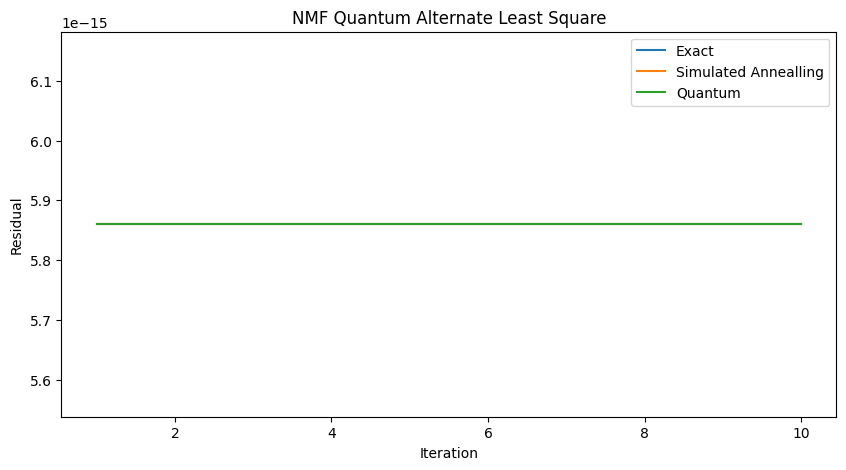

In [45]:
plt.figure(figsize=(10,5))

plt.title('NMF Quantum Alternate Least Square')
plt.plot(iter_list_ex, residuals_ex,'-',ms=2, label='Exact')#,label='residuals '+str(i+1))
plt.plot(iter_list_sa, residuals_sa,'-',ms=2,label='Simulated Annealling')#,label='residuals '+str(i+1))
plt.plot(iter_list_qu, residuals_qu,'-',ms=2,label='Quantum')#,label='residuals '+str(i+1))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residual')
#plt.xticks(np.arange(min(iter_list_exact)-1, max(iter_list_exact)+2, 2.0)) # para mostrar as iterações com espaçamento unitário
#plt.yticks(np.arange(min(np.round(residuals_exact,0))-1, max(np.round(residuals_exact,2))+1, 1.0)) # para mostrar as iterações com espaçamento unitário
#plt.savefig('bin02.png', format='png')
plt.show()

# Caso 3

In [26]:
#@title ⏯ Generating data

m = 100 # número de linhas de V
n = 80 # número de colunas de V
l = 8 # n_factors
k = 8 # n_qubits
p = 0.5 # probabilidade de sucesso na distribuição binomial
z = -1 # n_int_power (número de potências inteiras no vetor de precisão)
n_iter = 10
n_read = 20

np.random.seed(1)

delta = 1
W_original = random_positive_matrix(m,l,delta)
W_inicial = random_positive_matrix(m,l,delta)

#H_original = random_positive_matrix(l,n,delta) #np.random.randn(l,n)
#H_inicial = random_positive_matrix(l,n,delta)
H_original = np.array([np.random.binomial(1, p, n) for _ in range(l)])
H_inicial = np.array([np.random.binomial(1, p, n) for _ in range(l)])

V_original = W_original@H_original # Linear mixing model
V = V_original
#H_inicial
#print(f'\n\n WH = V:\n {V_original} \n\n W:\n {W_original} \n\n H:\n {H_original} \n\n W_inicial:\n {W_inicial}')
#print(f'V:\n {W_original}')

In [22]:
W_ex, H_ex, residuals_ex, rmse_ex, iter_list_ex = quantum_binals(V_original, W_inicial, n_factors=l, sampler='EXACT', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_ex,'\n\n','H=',H_ex,'\n\n','WH=',W_ex@H_ex,'\n\n','RMSE=',rmse_ex)

V= [[1.4101  1.55074 1.04474 ... 0.60262 2.11444 0.9169 ]
 [1.31976 1.13037 0.89529 ... 0.35844 1.34374 0.59438]
 [0.65096 0.71238 0.56334 ... 0.1705  1.11268 0.55401]
 ...
 [1.1751  1.36389 0.90187 ... 0.34429 1.38046 0.76091]
 [1.541   1.23161 0.32145 ... 0.39907 1.30675 1.15214]
 [0.89232 0.88661 0.57008 ... 0.18949 1.141   0.67848]] 

 W= [[ 4.17964369e-01  3.20082186e-01  6.16699953e-01  1.14371114e-01
   3.98913947e-01  1.88644243e-01  3.04375181e-01  7.98713789e-01]
 [-1.34581992e-02  4.20225380e-01  5.90140438e-01  2.25768980e-01
   3.72150724e-01  3.76637169e-01  4.43793063e-01  3.67164444e-01]
 [ 8.01566188e-02  1.16461966e-01  4.21987805e-01  1.06430494e-01
   3.61468857e-01  9.94805564e-02  8.57225034e-02  4.46401850e-01]
 [ 1.81012612e-01  2.43394590e-01  3.12158678e-01  5.06318879e-02
   2.73814446e-01  1.12297684e-01  1.19601195e-01  2.88174266e-01]
 [ 2.43088309e-01  1.21583348e-02  4.35775262e-01  1.92090580e-01
   4.30044466e-01  1.57977999e-01  2.88607590e-01  2.3082

In [23]:
W_sa, H_sa, residuals_sa, rmse_sa, iter_list_sa = quantum_binals(V_original, W_inicial, n_factors=l, sampler='SA', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_sa,'\n\n','H=',H_sa,'\n\n','WH=',W_sa@H_sa,'\n\n','RMSE=',rmse_sa)

V= [[1.4101  1.55074 1.04474 ... 0.60262 2.11444 0.9169 ]
 [1.31976 1.13037 0.89529 ... 0.35844 1.34374 0.59438]
 [0.65096 0.71238 0.56334 ... 0.1705  1.11268 0.55401]
 ...
 [1.1751  1.36389 0.90187 ... 0.34429 1.38046 0.76091]
 [1.541   1.23161 0.32145 ... 0.39907 1.30675 1.15214]
 [0.89232 0.88661 0.57008 ... 0.18949 1.141   0.67848]] 

 W= [[ 0.42370987  0.28667195  0.61340908  0.11605643  0.37525333  0.19680768
   0.32071478  0.79044129]
 [-0.00873855  0.44249288  0.58600261  0.21506992  0.38841247  0.38004613
   0.42275577  0.38377262]
 [ 0.06875294  0.12275796  0.42274099  0.11507321  0.3632748   0.10049223
   0.086293    0.44797183]
 [ 0.18589181  0.22698433  0.3086169   0.04984177  0.26296361  0.11864228
   0.12447873  0.28763506]
 [ 0.23305817  0.01284494  0.44013545  0.20029675  0.42745618  0.15402077
   0.2970848   0.22326868]
 [-0.04291666  0.39219145  0.36308754  0.13318459  0.39953937  0.56539976
   0.128398    0.45073203]
 [ 0.05620456  0.04647514  0.28622268  0.16590714

In [9]:
W_qu, H_qu, residuals_qu, rmse_qu, iter_list_qu = quantum_binals(V_original, W_inicial, n_factors=l, sampler='QUANTUM', n_reads=n_read, n_iters=n_iter)
print('V=', V,'\n\n','W=',W_qu,'\n\n','H=',H_qu,'\n\n','WH=',W_qu@H_qu,'\n\n','RMSE=',rmse_qu)

V= [[1.4101  1.55074 1.04474 ... 0.60262 2.11444 0.9169 ]
 [1.31976 1.13037 0.89529 ... 0.35844 1.34374 0.59438]
 [0.65096 0.71238 0.56334 ... 0.1705  1.11268 0.55401]
 ...
 [1.1751  1.36389 0.90187 ... 0.34429 1.38046 0.76091]
 [1.541   1.23161 0.32145 ... 0.39907 1.30675 1.15214]
 [0.89232 0.88661 0.57008 ... 0.18949 1.141   0.67848]] 

 W= [[ 4.06787649e-01  2.30741814e-01  4.99845182e-01  1.22058306e-01
   3.40992592e-01  2.14958630e-01  3.98003273e-01  8.14520642e-01]
 [ 7.18926501e-02  3.87779032e-01  4.86881948e-01  2.38885164e-01
   3.94935213e-01  3.49091888e-01  3.74923930e-01  3.87082617e-01]
 [ 4.90534319e-02  1.55753703e-01  4.25993226e-01  1.03884369e-01
   3.17971147e-01  1.04784639e-01  1.61654964e-01  4.37917974e-01]
 [ 2.11529192e-01  2.16379544e-01  2.49120551e-01  5.17698170e-02
   2.45215769e-01  1.09634118e-01  1.48328980e-01  3.02973539e-01]
 [ 1.96160612e-01  7.77601069e-02  4.41888801e-01  1.83652176e-01
   3.83253665e-01  1.57390897e-01  3.59972304e-01  2.0849

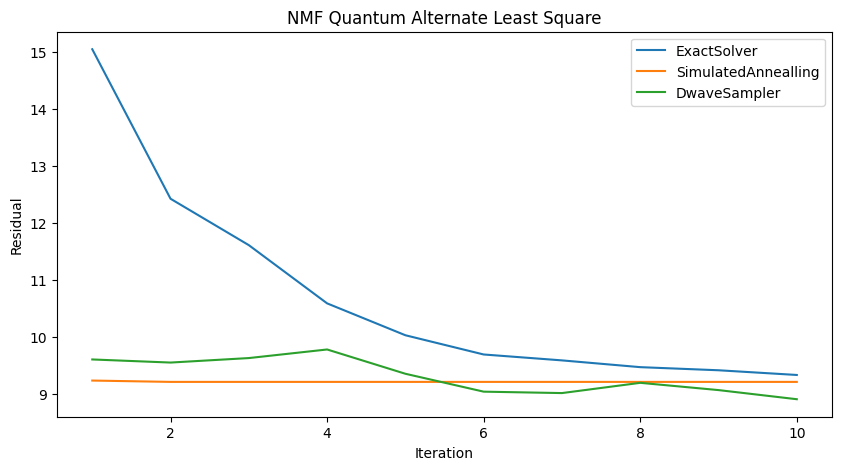

In [30]:
plt.figure(figsize=(10,5))

plt.title('NMF Quantum Alternate Least Square')
plt.plot(iter_list_ex, residuals_ex,'-',ms=2, label='ExactSolver')#,label='residuals '+str(i+1))
plt.plot(iter_list_sa, residuals_sa,'-',ms=2,label='SimulatedAnnealling')#,label='residuals '+str(i+1))
plt.plot(iter_list_qu, residuals_qu,'-',ms=2,label='DwaveSampler')#,label='residuals '+str(i+1))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residual')
#plt.xticks(np.arange(min(iter_list_exact)-1, max(iter_list_exact)+2, 2.0)) # para mostrar as iterações com espaçamento unitário
#plt.yticks(np.arange(min(np.round(residuals_exact,0))-1, max(np.round(residuals_exact,2))+1, 1.0)) # para mostrar as iterações com espaçamento unitário
#plt.savefig('bin02.png', format='png')
plt.show()

In [28]:
residuals_sa

array([9.23918444, 9.21574713, 9.21574713, 9.21574713, 9.21574713,
       9.21574713, 9.21574713, 9.21574713, 9.21574713, 9.21574713])